<div class="alert alert-block alert-info">
<b><h2><center>Data Science Project - Marketing analysis</center></h2></b>


Machine Learning</div>

By Eduardo Teixeira de Aguiar Veiga

Contact: etaveiga@gmail.com
<nav>
<a href="https://www.linkedin.com/in/eduardo-veiga-0728221a6/">LinkedIn</a> |
<a href="https://github.com/eduardotaveiga">Github</a> |
</nav>

If you have any suggestions (including english tips!) feel free to send me a message!

![](https://images.unsplash.com/photo-1460925895917-afdab827c52f?crop=entropy&cs=tinysrgb&fm=jpg&ixlib=rb-1.2.1&q=80&raw_url=true&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1115)

*Image source: https://unsplash.com/photos/hpjSkU2UYSU*

<div class="alert alert-block alert-info">
<b><h2><center>Case study:</center></h2></b></div>

*This notebook is intended to be a continuation of the previous one entitled ''EDA and Segmentation''*

Great! Now that we have a better understanding of our customer base, it's time to apply some machine learning stuff. The CMO of Company XYZ comes to you and says that the total cost of the new campaign was 6.72 million and the total revenue generated (by the people who accepted) was 3.674 million. Also, the success of the campaign was 15% (but we already knew that).

Hence, the CMO is looking for a predictive model that maximizes profits, picking the customers who are more likely to purchase the new offer, while leaving the non-respondents.

Dataset source: https://github.com/nailson/ifood-data-business-analyst-test

---

Summary:

>[How we will evaluate the model?](#howevaluate)  
>[Feature selection](#featureselection)  
>[Train and Test split](#traintestsplit)  
>[Model benchmark](#modelbenchmark)  
>[Hyperparamter tuning](#hyperparameter)  
>[Underfitting](#underfitting)  
>[The best model](#bestmodel)  
>[Understanding predictions](#understandingpredicitions)  

In [1]:
# Necessary libraries
import pandas as pd  # DataFrame
import numpy as np

# Plot charts
import plotly.express as px   
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'notebook' # Render charts inside notebook

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from xgboost.sklearn import XGBClassifier

import optuna

import shap

import warnings
warnings.filterwarnings("ignore")


### Getting the data

In [2]:
df = pd.read_csv('ML_data.csv')
df

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2203  10870        1967  Graduation        Married  61223.0        0   
2204   4001        1946         PhD       Together  64014.0        2   
2205   7270        1981  Graduation       Divorced  56981.0        0   
2206   8235        1956      Master       Together  69245.0        0   
2207   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  Complain  Response  \
0            0  2012-09-04       58       635  ...         0         1   
1            1  2014-03-08       38        11  ...         0         0   
2            0  2013-08-21       26       426  ...         0         0   
3            0  2014-02-10       26        11  ...         0         0   
4            0  2014-01-19       94       173  ...         0         0   
...        ...         ...      ...       ...  ...       ...       ...   
2203         1  2013-06-13       46       709  ...         0         0   
2204         1  2014-06-10       56       406  ...         0         0   
2205         0  2014-01-25       91       908  ...         0         0   
2206         1  2014-01-24        8       428  ...         0         0   
2207         1  2012-10-15       40        84  ...         0         1   

      Marital_encoded  Age  AcceptedCmpOverall  MntTotal  PurchasesTotal  \
0                   0   65                   0      1617              22   
1                   0   68                   0        27               4   
2                   3   57                   0       776              20   
3                   3   38                   0        53               6   
4                   2   41                   0       422              14   
...               ...  ...                 ...       ...             ...   
2203                2   55                   0      1341              16   
2204                3   76                   1       444              15   
2205                1   41                   1      1241              18   
2206                3   66                   0       843              21   
2207                2   68                   0       172               8   

      Education_encoded  Family_size  Cluster  
0                     1            0        2  
1                     1            2        0  
2                     1            0        1  
3                     1            1        0  
4                     3            1        3  
...                 ...          ...      ...  
2203                  1            1        1  
2204                  3            3        3  
2205                  1            0        1  
2206                  2            1        1  
2207                  3            2        3  

[2208 rows x 35 columns]

<a id="howevaluate"></a>

<div class="alert alert-block alert-info">
<b><h2><center>How we will evaluate the model?</center></h2></b>

The CMO wants to target only the likely to respond customers, but, since the dataset is unbalanced, that is, 85% of our data are from non-respondents (0) and only 15% are from actual buyers (1), doesn't make sense to use only accuracy to evaluate our Machine Learning model, because, if we do so, we will not account for **false positives** and **false negatives**.

>**False positive:** The model predicts that they would accept the offer, but, in reality, they wouldn't  
>>It will <mark>increases costs</mark> and <mark>don't provide any revenue</mark>  

>**False negative:** The model predict that they wouldn't accept the offer, but they actually would 
>> Do not increases costs but <mark>don't generate any revenue</mark>

We can look at Precision and Recall scores. In a basic and straightfoward way, high Precision means low rate of false positives, while high recall means low rate of false negatives. There is a tradeoff between them, since a higher value of one is usually followed by a lower value of the other, and the optimal point (the balanced) should be chosen considering our business problem.

In our case, we would like to have a high Precision, to avoid unnecessary costs, *and* high Recall, to send the campaign to the maximum number of truly respondents. This can be achieved by optimizing a metric called AUC. A high value of AUC indicates high Precision and high Recall at the same time (as far as possible), and, in order to maximize profits, the balance between them will be calculated using expected value structure.

$EV=p(o_{1})\cdot v(o_{1})+p(o_{2})\cdot v(o_{2})+p(o_{3})\cdot v(o_{3})+ ...$

Where $p(o_{n})$ is the probability of the $v(o_{n})$ value. Later we will modify this equation to better fit our purposes.


<a id="featureselection"></a>

<div class="alert alert-block alert-info">
<b><h2><center>Feature selection</center></h2></b>


In this step, we aim to select the features that will return the best model performance, while caring for complexity and interpretability.

First thing first, let's drop some unimportant columns like

>**ID:** No useful information   
**Year_Birth:** Basicaly the same data as Age   
**Education:** We encoded it   
**Marital_Status:** We encoded it    
**Dt_Customer:** No useful information  

In [3]:
df = df.drop(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Dt_Customer'], axis='columns')

Then, there are four ways of selecting features:

> Actually selecting all features  
>> But we should be careful of high model complexity (overfitting) and difficulty to interpret  

> Using correlations  
>> Better with Linear Models  

>Using univariate feature selection  
>>KBest function with chi2 test  

>Using Recursive Feature Flimination  
>>It's computationally expensive and requires a previous stablished model  

<div class="alert alert-block alert-warning">
<b>Keep in mind:</b> Response column is the target feature
</div>

In [4]:
all_features = [
    'Income', 'Kidhome','Teenhome', 'Recency', 
    'MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds', 
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 
    'Marital_encoded', 'Age', 'AcceptedCmpOverall', 'MntTotal', 'PurchasesTotal', 'Education_encoded',
    'Family_size', 'Cluster']

### Correlation

High (positive or negative) correlation with Response

In [5]:
def colors(styler):
    styler.background_gradient(axis=None, vmin=correlation.min(), vmax=1, cmap="YlGnBu")
    return styler


correlation = df.corr()['Response'].sort_values(ascending=False)

data_cor = pd.DataFrame(data=correlation, index=correlation.index)
data_cor.style.pipe(colors)

Let's use columns with correlation higher than 0.15

In [6]:
correlation_features = data_cor[abs(data_cor['Response']) >= 0.15 ].index[1:]  # First feature is Response itself
correlation_features

Index(['AcceptedCmpOverall', 'AcceptedCmp5', 'AcceptedCmp1', 'MntTotal',
       'AcceptedCmp3', 'MntWines', 'MntMeatProducts', 'NumCatalogPurchases',
       'AcceptedCmp4', 'AcceptedCmp2', 'PurchasesTotal', 'Income',
       'NumWebPurchases', 'Teenhome', 'Family_size', 'Recency'],
      dtype='object')

### Select KBest

Here, we have to specify the number of features that we want to maintain. Let's start by setting 16 of them (same lenght as correlation features).

In [7]:
ml_df = df[all_features].copy()

X = ml_df
y = df['Response']

X = SelectKBest(chi2, k=16).fit_transform(X, y)

idx = 0
kbest_features = []
for col in ml_df.columns:
    try:
        test_array = ml_df[col].values == X[:, idx]
        if len(np.where(test_array == False)[0]) == 0:
            kbest_features.append(col)
            idx += 1
    except:
        break

kbest_features

['Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'AcceptedCmp3',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmpOverall',
 'MntTotal',
 'PurchasesTotal']

### RFE

We will use RFE later when a model benchmark will be made in order to see if we can improve the model performance.

### Understanding our subsets

The all_features subset is straightfoward: simply uses all features. We may try to visualize feature coefficients (for linear models) or feature importances (for ensembles) in order to understanding the significative characteristics, but there is a chance that we will be surprised by the features that the model is focusing on. In order words, it's probably hard to interpret.

The correlation features is mainly about past acceptance of campaigns and the features that affect them, like income and family size. It's somwhat easier to explain.

Finally, the KBest is mainly focused on customer behaviours, like the amount of products and purchases, along with past campaign acceptance. It's somewhat easier to explain.


<a id="traintestsplit"></a>

<div class="alert alert-block alert-info">
<b><h2><center>Train and Test split</center></h2></b>

There is one more thing to be done concerning the evaluation process: we will split the dataset in two parts. The *train* portion will be used to fit the model, while the *test* portion will be actually used to measure how well it will perform in a generalized customer base (we will set our precision-recall balance here).  

The problem is, we can't just split randomly. Since the dataset is unbalanced, there is a high chance of a portion being formed of little or no respondent customers, which would be an issue for our model. Fortunately, scikit-learn handles this problem for us, so we simply need to specify a <mark>stratify</mark> parameter in <mark>train_test_split</mark> function.

<a id="modelbenchmark"></a>

<div class="alert alert-block alert-info">
<b><h2><center>Model benchmark</center></h2></b>


Let's set a workflow here

1. Get a subset of features
2. Select a specific model
3. Evaluate the model with default parameters using cross-validation
4. Compare model performance with non-scaled features with the one with scaled features

In [8]:
def train_cross_val(X_train, y_train, model, n_splits=5, scoring='accuracy'):
    results = np.array([])
    for c in range(1, 10):
        kfold = StratifiedKFold(n_splits=n_splits)
        score = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        results = np.concatenate([results, score])
    
    return results

In [9]:
def visualize_model(models, features=(all_features, correlation_features, kbest_features), features_names=('All', 'Correlation', 'KBest')):
    model_names = []
    
    noscale_mean_values = []
    noscale_std_values = []

    standard_mean_values = []
    standard_std_values = []

    minmax_mean_values = []
    minmax_std_values = []

    idx = 0
    for model in models:
        for feature in features:
            X_train, X_test, y_train, y_test = train_test_split(df[feature], df['Response'], stratify=y, test_size=0.3, random_state=42)
            result = train_cross_val(X_train, y_train, model, n_splits=5, scoring='roc_auc')
            noscale_mean_values.append(result.mean())
            noscale_std_values.append(result.std())
            model_names.append(type(model).__name__)

            fig = go.Figure()
            fig.add_trace(go.Box(y=result, name='NoScaling'))

            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            result = train_cross_val(X_train_scaled, y_train, model, n_splits=5, scoring='roc_auc')
            standard_mean_values.append(result.mean())
            standard_std_values.append(result.std())
            fig.add_trace(go.Box(y=result, name='StandardScaler'))

            scaler = MinMaxScaler()
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            result = train_cross_val(X_train_scaled, y_train, model, n_splits=5, scoring='roc_auc')
            minmax_mean_values.append(result.mean())
            minmax_std_values.append(result.std())
            fig.add_trace(go.Box(y=result, name='MinMaxScaler'))

            fig.update_layout(title=f'{type(model).__name__}: {features_names[idx]}')
            fig.update_yaxes(title='AUC score')
            idx += 1
            fig.show()

        idx = 0
    

    data = {'Model':model_names,
            'Features':features_names*len(models),
        'NoScaling_mean':noscale_mean_values, 'NoScaling_std':noscale_std_values,
       'StandardScaler_mean':standard_mean_values, 'StandardScaler_std':standard_std_values,
       'MinMaxScaler_mean':minmax_mean_values, 'MinMaxScaler_std':minmax_std_values}
    table = pd.DataFrame(data=data)
    table.set_index(['Model', 'Features'], inplace=True)
    
    return table

### Linear Models

Let's compare three linear models for classification: Ridge, LogistcRegression and LinearSVC

In [10]:
linear_table = visualize_model([RidgeClassifier(), LogisticRegression(), LinearSVC()])


In [11]:
linear_table.style.bar(color='#5ccad6')

In general, Linear models are perfoming better on the subset that contains all features, followed by the correlation subset and KBest subset. LR and LinearSVC are better used with scaled features.

When features are scaled, the best model tend to be LinearSVC, followed by LogisticRegression.

The higher mean value is around 0.85 with std of 0.022.

### Non-Linear models

Let's compare two non-linear models for classification: KNearestNeighbors and SVC(kernel='rbf)

In [12]:
nonlinear_table = visualize_model([KNeighborsClassifier(), SVC()])


In [13]:
nonlinear_table.style.bar(color='#5ccad6')

KNN and SVC are perfoming better on the all_features dataset and they require the use of StandardScaler.

When features are scaled, the best model tend to be SVC.

The high mean value is around 0.86 with std of 0.029

### Ensembles

Let's compare three ensembles models for classification: Random Forests, Gradient Boosting Trees and XGBoost

In [14]:
ensembles_table = visualize_model([RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier()])

In [15]:
ensembles_table.style.bar(color='#5ccad6')

For the ensemble methods, scaling the features doesn't provide any improvement. 

For the Random Forest, it's performing better on the all_features subset, followed by the KBest and Correlation. The other two also are better on the All_features, but the correlation subset is better than the KBest one. The best model tend to be XGB.

The high mean value is 0.88 with std of 0.024

### What about RFE?

RFE requires a model that put weights on features, like coefficients or feature importances. Based on our benchmark, we will apply RFE on the all_features subset using LinearSVC and XGB.

#### RFE and LinearSVC

In [16]:
X = df[all_features]
y = df['Response']

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

linear_selector = RFECV(LinearSVC(), cv=StratifiedKFold(n_splits=5), scoring='roc_auc').fit(X_scaled, y)
print(linear_selector.support_)
print(linear_selector.ranking_) # Best features are ranked as 1

data = {'column':df[all_features].columns, 'ranking':linear_selector.ranking_, 'used':linear_selector.support_}
linear_selector_table = pd.DataFrame(data=data)

[False  True  True  True False False  True False False  True  True  True
  True  True  True  True False  True False False False  True  True  True
 False False  True  True False]
[ 7  1  1  1  9  5  1 13 11  1  1  1  1  1  1  1  2  1  3  4 12  1  1  1
  8 10  1  1  6]


In [17]:
px.bar(linear_selector_table.sort_values(by='ranking'), y='column', x='ranking', color='used', orientation='h').update_layout(height=800)

In [18]:
linear_rfe_features = linear_selector_table[linear_selector_table['used'] == True]['column'].values
linear_rfe_features

array(['Kidhome', 'Teenhome', 'Recency', 'MntMeatProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp5', 'Marital_encoded', 'Age',
       'AcceptedCmpOverall', 'Education_encoded', 'Family_size'],
      dtype=object)

The RFE along with LinearSVC is selecting a mix of customer behaviour, past campaign acceptance and demographics. It's easier to explain than selecting all_features. Let's see the overall performance of the ML models.

In [19]:
linear_rfe_table = visualize_model([RidgeClassifier(), LogisticRegression(), LinearSVC(), SVC(), RandomForestClassifier(), XGBClassifier()], features=[linear_rfe_features], features_names=['Linear_RFE'])

In [20]:
linear_rfe_table.style.bar(color='#5ccad6')

Using the linear_rfe subset of features, both linear models and ensembles had their general mean performances increased slightly, while SVC decreased a little bit.

#### RFE and XGBoost

In [21]:
xgb_selector = RFECV(XGBClassifier(), cv=StratifiedKFold(n_splits=5), scoring='roc_auc').fit(X, y)
print(xgb_selector.support_)
print(xgb_selector.ranking_) # Best features are ranked as 1

data = {'column':df[all_features].columns, 'ranking':xgb_selector.ranking_, 'used':xgb_selector.support_}
xgb_selector_table = pd.DataFrame(data=data)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]


In [22]:
px.bar(xgb_selector_table.sort_values(by='ranking'), y='column', x='ranking', color='used', orientation='h').update_layout(height=800)

In [23]:
xgb_rfe_features = xgb_selector_table[xgb_selector_table['used'] == True]['column'].values
xgb_rfe_features

array(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Marital_encoded',
       'Age', 'AcceptedCmpOverall', 'MntTotal', 'PurchasesTotal',
       'Education_encoded', 'Family_size', 'Cluster'], dtype=object)

RFE along with XGB is actually selecting everything but the Complain column. In this case we didn't remove much complexity, but we should verify if we gained any performance.

In [24]:
xgb_rfe_table = visualize_model([RidgeClassifier(), LogisticRegression(), LinearSVC(), SVC(), RandomForestClassifier(), XGBClassifier()], features=[xgb_rfe_features], features_names=['XGB_RFE'])

In [25]:
xgb_rfe_table.style.bar(color='#5ccad6')

Every performance increased a little bit, compared to using all_features.

Here, for brevity, I intend to compare (after tuning) three models and two subsets of features. At the end, the models will be differentiated using expected value structure, while the subset will be selected based on higher AUC score.

Let's set a workflow here.

1. Pick a subset of features  
2. Tune model hyperparameters  
3. Do the same with the other subset  
4. Compare AUC from both subsets  
5. Return the best subset for a given model  

<a id="hyperparameter"></a>

<div class="alert alert-block alert-info">
<b><h2><center>Hyperparameter tuning</center></h2></b>


Now we will try to gain more performance by tuning the models hyperparameters. For this task, I'll be using <mark>optuna</mark> library, which is faster and provides good results.

The models (and subset of features) are the following:

LinearSVC()  
SVC(kernel='rbf')   
XGBClassifier()  
>Linear RFE  
>XGB RFE  


<div class="alert alert-block alert-warning">
<b>Note:</b> Random_state will be specified for reproducibility

### LinearSVC

There are two variables that we want to pay attention in LinearSVC

>**C:** determines the strenght of the regularization (l2 as default). A Higher value of C means *less* regularization and a more complex model, since it will try to fit the training set as best as possible.  
>**class_weight:** determines the weight of each class. It's important to verify it effects since we have an unbalanced dataset.  

In [26]:
def objective(trial):  # Optuna function
    # LinSVC optimization
    
    linsvc_C = trial.suggest_float('linsvc_C', 0.1, 100)
    linsvc_class_weight = trial.suggest_categorical('linsvc_class_wieght', ['balanced', None])
    
    classifier_obj = LinearSVC(C=linsvc_C, class_weight=linsvc_class_weight, random_state=42)
        
    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    roc_auc = score.mean()
    return roc_auc

In [27]:
# Linear RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[linear_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)
print('Linear RFE Features')
print('Best mean AUC found:', study.best_trial.values)
print('Best params found:', study.best_trial.params)

linsvc = LinearSVC()
no_tuning_auc_train = cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
no_tuning_auc_test = cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

bestparams = study.best_trial.params
linsvc = LinearSVC(C=bestparams['linsvc_C'], class_weight=bestparams['linsvc_class_wieght'])
tuning_auc_train = cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
tuning_auc_test = cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

print()
print('Train Tuning AUC mean:', tuning_auc_train, '          Test Tuning AUC mean:', tuning_auc_test)
print('Train No-Tuning AUC mean:', no_tuning_auc_train, '       Test No-Tuning AUC mean:', no_tuning_auc_test)

[I 2022-06-05 14:05:59,883] A new study created in memory with name: no-name-6f273e89-5924-4a89-a21f-ec3726367566
[I 2022-06-05 14:06:00,035] Trial 0 finished with value: 0.8096699634485764 and parameters: {'linsvc_C': 37.516557872851514, 'linsvc_class_wieght': 'balanced'}. Best is trial 0 with value: 0.8096699634485764.
[I 2022-06-05 14:06:00,184] Trial 1 finished with value: 0.7267867837381218 and parameters: {'linsvc_C': 59.905982571283964, 'linsvc_class_wieght': 'balanced'}. Best is trial 0 with value: 0.8096699634485764.
[I 2022-06-05 14:06:00,312] Trial 2 finished with value: 0.8580306053430308 and parameters: {'linsvc_C': 5.902552855603126, 'linsvc_class_wieght': 'balanced'}. Best is trial 2 with value: 0.8580306053430308.
[I 2022-06-05 14:06:00,415] Trial 3 finished with value: 0.7845699230202546 and parameters: {'linsvc_C': 70.83645052182494, 'linsvc_class_wieght': None}. Best is trial 2 with value: 0.8580306053430308.
[I 2022-06-05 14:06:00,547] Trial 4 finished with value: 0

[I 2022-06-05 14:06:04,965] Trial 37 finished with value: 0.8275354876864653 and parameters: {'linsvc_C': 16.206006596675042, 'linsvc_class_wieght': 'balanced'}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:05,082] Trial 38 finished with value: 0.7598960406531113 and parameters: {'linsvc_C': 63.37703527539131, 'linsvc_class_wieght': 'balanced'}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:05,228] Trial 39 finished with value: 0.8405838795309585 and parameters: {'linsvc_C': 18.738348882714984, 'linsvc_class_wieght': 'balanced'}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:05,362] Trial 40 finished with value: 0.7785503373685311 and parameters: {'linsvc_C': 80.76327150088984, 'linsvc_class_wieght': 'balanced'}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:05,464] Trial 41 finished with value: 0.8528100704191713 and parameters: {'linsvc_C': 11.094187260314909, 'linsvc_class_wieght': None}. Be

[I 2022-06-05 14:06:10,062] Trial 75 finished with value: 0.8123068636077523 and parameters: {'linsvc_C': 24.474565373570453, 'linsvc_class_wieght': 'balanced'}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:10,179] Trial 76 finished with value: 0.7572018287767541 and parameters: {'linsvc_C': 89.21545086219362, 'linsvc_class_wieght': None}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:10,312] Trial 77 finished with value: 0.7873263601974165 and parameters: {'linsvc_C': 50.3134456012087, 'linsvc_class_wieght': 'balanced'}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:10,430] Trial 78 finished with value: 0.8105965632892527 and parameters: {'linsvc_C': 19.60477448102465, 'linsvc_class_wieght': 'balanced'}. Best is trial 14 with value: 0.8603012448309034.
[I 2022-06-05 14:06:10,548] Trial 79 finished with value: 0.8605634315050337 and parameters: {'linsvc_C': 2.529165046502239, 'linsvc_class_wieght': 'balanced'}. Best 

Linear RFE Features
Best mean AUC found: [0.8605634315050337]
Best params found: {'linsvc_C': 2.529165046502239, 'linsvc_class_wieght': 'balanced'}

Train Tuning AUC mean: 0.8603177764890285           Test Tuning AUC mean: 0.8959540305409541
Train No-Tuning AUC mean: 0.8545682365602143        Test No-Tuning AUC mean: 0.8978868770377272


In [28]:
#XGB RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[xgb_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)
print('Linear RFE Features')
print('Best mean AUC found:', study.best_trial.values)
print('Best params found:', study.best_trial.params)

linsvc = LinearSVC()
no_tuning_auc_train = cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
no_tuning_auc_test = cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

bestparams = study.best_trial.params
linsvc = LinearSVC(C=bestparams['linsvc_C'], class_weight=bestparams['linsvc_class_wieght'])
tuning_auc_train = cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
tuning_auc_test = cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

print()
print('Train Tuning AUC mean:', tuning_auc_train, '          Test Tuning AUC mean:', tuning_auc_test)
print('Train No-Tuning AUC mean:', no_tuning_auc_train, '       Test No-Tuning AUC mean:', no_tuning_auc_test)

[I 2022-06-05 14:06:14,016] A new study created in memory with name: no-name-a7ab3e9f-8307-4ef2-a15b-d2fc8f695c05
[I 2022-06-05 14:06:14,179] Trial 0 finished with value: 0.7553439464233582 and parameters: {'linsvc_C': 37.516557872851514, 'linsvc_class_wieght': 'balanced'}. Best is trial 0 with value: 0.7553439464233582.
[I 2022-06-05 14:06:14,392] Trial 1 finished with value: 0.7344357593646796 and parameters: {'linsvc_C': 59.905982571283964, 'linsvc_class_wieght': 'balanced'}. Best is trial 0 with value: 0.7553439464233582.
[I 2022-06-05 14:06:14,577] Trial 2 finished with value: 0.8377897393257967 and parameters: {'linsvc_C': 5.902552855603126, 'linsvc_class_wieght': 'balanced'}. Best is trial 2 with value: 0.8377897393257967.
[I 2022-06-05 14:06:14,761] Trial 3 finished with value: 0.7512611504449894 and parameters: {'linsvc_C': 70.83645052182494, 'linsvc_class_wieght': None}. Best is trial 2 with value: 0.8377897393257967.
[I 2022-06-05 14:06:14,943] Trial 4 finished with value: 0

[I 2022-06-05 14:06:21,060] Trial 37 finished with value: 0.8196202736930518 and parameters: {'linsvc_C': 16.206006596675042, 'linsvc_class_wieght': 'balanced'}. Best is trial 24 with value: 0.854527625657316.
[I 2022-06-05 14:06:21,227] Trial 38 finished with value: 0.7362077802005296 and parameters: {'linsvc_C': 63.37703527539131, 'linsvc_class_wieght': 'balanced'}. Best is trial 24 with value: 0.854527625657316.
[I 2022-06-05 14:06:21,410] Trial 39 finished with value: 0.8301625338282108 and parameters: {'linsvc_C': 18.738348882714984, 'linsvc_class_wieght': 'balanced'}. Best is trial 24 with value: 0.854527625657316.
[I 2022-06-05 14:06:21,593] Trial 40 finished with value: 0.7215729130298653 and parameters: {'linsvc_C': 80.76327150088984, 'linsvc_class_wieght': 'balanced'}. Best is trial 24 with value: 0.854527625657316.
[I 2022-06-05 14:06:21,747] Trial 41 finished with value: 0.8340921575634296 and parameters: {'linsvc_C': 11.094187260314909, 'linsvc_class_wieght': None}. Best i

[I 2022-06-05 14:06:27,995] Trial 75 finished with value: 0.7883687272902824 and parameters: {'linsvc_C': 24.474565373570453, 'linsvc_class_wieght': 'balanced'}. Best is trial 57 with value: 0.8550949243943128.
[I 2022-06-05 14:06:28,177] Trial 76 finished with value: 0.7450890369545254 and parameters: {'linsvc_C': 89.21545086219362, 'linsvc_class_wieght': None}. Best is trial 57 with value: 0.8550949243943128.
[I 2022-06-05 14:06:28,365] Trial 77 finished with value: 0.7781013861863807 and parameters: {'linsvc_C': 50.3134456012087, 'linsvc_class_wieght': 'balanced'}. Best is trial 57 with value: 0.8550949243943128.
[I 2022-06-05 14:06:28,623] Trial 78 finished with value: 0.7940153370397506 and parameters: {'linsvc_C': 19.60477448102465, 'linsvc_class_wieght': 'balanced'}. Best is trial 57 with value: 0.8550949243943128.
[I 2022-06-05 14:06:28,826] Trial 79 finished with value: 0.85237734748807 and parameters: {'linsvc_C': 2.529165046502239, 'linsvc_class_wieght': 'balanced'}. Best is

Linear RFE Features
Best mean AUC found: [0.8550949243943128]
Best params found: {'linsvc_C': 1.7571241098928299, 'linsvc_class_wieght': 'balanced'}

Train Tuning AUC mean: 0.8527973085268424           Test Tuning AUC mean: 0.8888060167010448
Train No-Tuning AUC mean: 0.8521679509601799        Test No-Tuning AUC mean: 0.8914365559917492


### SVC with kernel rbf

SVC will be used with radial basis function (rbf) kernel, which basically considers all possible polynomials features of all degrees, but decreasing feature importances as the degree grows. SVC tries to make a classification by considering the distance between the *support vectors* (data points close to the decision boundary) and a new point. 

We want to pay attention for three variables:

>**C:** Again, it determines the strength of regularization  
>**gamma:** The width of kernel, or, the scale of what means by two points being considered "close", is set by the gamma parameter. A higher value of gamma restricts the distance and creates more single point focused boundaries, meaning a more complex model.
>**class_weight:** Again, we should verify its effects on a unbalanced dataset

In [29]:
def objective(trial):  # Optuna function
    # SVC optimization
    
    svc_C = trial.suggest_float('svc_C', 0.1, 100)
    svc_gamma = trial.suggest_float('svc_gamma', 0.01, 10)
    svc_class_weight = trial.suggest_categorical('svc_class_weight', ['balanced', None])
    
    classifier_obj = SVC(C=svc_C, class_weight=svc_class_weight, gamma=svc_gamma)
        
    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    roc_auc = score.mean()
    return roc_auc

In [30]:
# Linear RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[linear_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)
print('Linear RFE Features')
print('Best mean AUC found:', study.best_trial.values)
print('Best params found:', study.best_trial.params)

svc = SVC()
no_tuning_auc_train = cross_val_score(svc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
no_tuning_auc_test = cross_val_score(svc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

bestparams = study.best_trial.params
svc = SVC(C=bestparams['svc_C'], gamma=bestparams['svc_gamma'], class_weight=bestparams['svc_class_weight'])
tuning_auc_train = cross_val_score(svc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
tuning_auc_test = cross_val_score(svc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

print()
print('Train Tuning AUC mean:', tuning_auc_train, '          Test Tuning AUC mean:', tuning_auc_test)
print('Train No-Tuning AUC mean:', no_tuning_auc_train, '       Test No-Tuning AUC mean:', no_tuning_auc_test)

[I 2022-06-05 14:06:34,100] A new study created in memory with name: no-name-31651b9d-b755-4913-bd57-cf602fc5f76f
[I 2022-06-05 14:06:34,316] Trial 0 finished with value: 0.7475515773905664 and parameters: {'svc_C': 37.516557872851514, 'svc_gamma': 9.507635921035062, 'svc_class_weight': 'balanced'}. Best is trial 0 with value: 0.7475515773905664.
[I 2022-06-05 14:06:34,527] Trial 1 finished with value: 0.7939825381978097 and parameters: {'svc_C': 15.686262180199408, 'svc_gamma': 1.5683852581586646, 'svc_class_weight': None}. Best is trial 1 with value: 0.7939825381978097.
[I 2022-06-05 14:06:34,742] Trial 2 finished with value: 0.7647300215368009 and parameters: {'svc_C': 60.15138967314657, 'svc_gamma': 7.0836450521824945, 'svc_class_weight': None}. Best is trial 1 with value: 0.7939825381978097.
[I 2022-06-05 14:06:34,943] Trial 3 finished with value: 0.78910380611289 and parameters: {'svc_C': 83.26101981596213, 'svc_gamma': 2.1312677156759787, 'svc_class_weight': None}. Best is trial

[I 2022-06-05 14:06:41,409] Trial 33 finished with value: 0.782808861086896 and parameters: {'svc_C': 12.074550196634913, 'svc_gamma': 3.382775562322243, 'svc_class_weight': 'balanced'}. Best is trial 7 with value: 0.8128791162036484.
[I 2022-06-05 14:06:41,640] Trial 34 finished with value: 0.7653867931410561 and parameters: {'svc_C': 51.927183112162275, 'svc_gamma': 7.033159399362827, 'svc_class_weight': None}. Best is trial 7 with value: 0.8128791162036484.
[I 2022-06-05 14:06:41,849] Trial 35 finished with value: 0.7866170951414512 and parameters: {'svc_C': 96.2484847647169, 'svc_gamma': 2.5253051352953877, 'svc_class_weight': 'balanced'}. Best is trial 7 with value: 0.8128791162036484.
[I 2022-06-05 14:06:42,014] Trial 36 finished with value: 0.8175860017426306 and parameters: {'svc_C': 28.555565388309017, 'svc_gamma': 0.37850060407178265, 'svc_class_weight': 'balanced'}. Best is trial 36 with value: 0.8175860017426306.
[I 2022-06-05 14:06:42,224] Trial 37 finished with value: 0.7

[I 2022-06-05 14:06:48,776] Trial 67 finished with value: 0.784850084549886 and parameters: {'svc_C': 36.013166006853545, 'svc_gamma': 2.9429825242022885, 'svc_class_weight': None}. Best is trial 51 with value: 0.838168501442647.
[I 2022-06-05 14:06:48,992] Trial 68 finished with value: 0.7506516996045478 and parameters: {'svc_C': 86.72052462615235, 'svc_gamma': 9.133273120039147, 'svc_class_weight': 'balanced'}. Best is trial 51 with value: 0.838168501442647.
[I 2022-06-05 14:06:49,257] Trial 69 finished with value: 0.768222987446492 and parameters: {'svc_C': 79.84968837878084, 'svc_gamma': 6.503139668469874, 'svc_class_weight': None}. Best is trial 51 with value: 0.838168501442647.
[I 2022-06-05 14:06:49,469] Trial 70 finished with value: 0.78276869186952 and parameters: {'svc_C': 89.01153364757488, 'svc_gamma': 3.3865716169468425, 'svc_class_weight': 'balanced'}. Best is trial 51 with value: 0.838168501442647.
[I 2022-06-05 14:06:49,675] Trial 71 finished with value: 0.8170848269531

Linear RFE Features
Best mean AUC found: [0.838168501442647]
Best params found: {'svc_C': 60.68226305999304, 'svc_gamma': 0.10187854565013017, 'svc_class_weight': None}

Train Tuning AUC mean: 0.838168501442647           Test Tuning AUC mean: 0.8433128035797457
Train No-Tuning AUC mean: 0.8577831916399912        Test No-Tuning AUC mean: 0.8673279992015436


In [31]:
#XGB RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[xgb_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)
print('Linear RFE Features')
print('Best mean AUC found:', study.best_trial.values)
print('Best params found:', study.best_trial.params)

svc = SVC()
no_tuning_auc_train = cross_val_score(svc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
no_tuning_auc_test = cross_val_score(svc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

bestparams = study.best_trial.params
svc = SVC(C=bestparams['svc_C'], gamma=bestparams['svc_gamma'], class_weight=bestparams['svc_class_weight'])
tuning_auc_train = cross_val_score(svc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
tuning_auc_test = cross_val_score(svc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

print()
print('Train Tuning AUC mean:', tuning_auc_train, '          Test Tuning AUC mean:', tuning_auc_test)
print('Train No-Tuning AUC mean:', no_tuning_auc_train, '       Test No-Tuning AUC mean:', no_tuning_auc_test)

[I 2022-06-05 14:06:56,316] A new study created in memory with name: no-name-28a11370-4fd9-408e-b700-9a0c2a64783c
[I 2022-06-05 14:06:56,569] Trial 0 finished with value: 0.6970709577592104 and parameters: {'svc_C': 37.516557872851514, 'svc_gamma': 9.507635921035062, 'svc_class_weight': 'balanced'}. Best is trial 0 with value: 0.6970709577592104.
[I 2022-06-05 14:06:56,777] Trial 1 finished with value: 0.7756336770899706 and parameters: {'svc_C': 15.686262180199408, 'svc_gamma': 1.5683852581586646, 'svc_class_weight': None}. Best is trial 1 with value: 0.7756336770899706.
[I 2022-06-05 14:06:57,026] Trial 2 finished with value: 0.7187043991582682 and parameters: {'svc_C': 60.15138967314657, 'svc_gamma': 7.0836450521824945, 'svc_class_weight': None}. Best is trial 1 with value: 0.7756336770899706.
[I 2022-06-05 14:06:57,307] Trial 3 finished with value: 0.7687453242083163 and parameters: {'svc_C': 83.26101981596213, 'svc_gamma': 2.1312677156759787, 'svc_class_weight': None}. Best is tri

[I 2022-06-05 14:07:04,295] Trial 33 finished with value: 0.7614535553711067 and parameters: {'svc_C': 12.074550196634913, 'svc_gamma': 3.382775562322243, 'svc_class_weight': 'balanced'}. Best is trial 7 with value: 0.8035903354159858.
[I 2022-06-05 14:07:04,525] Trial 34 finished with value: 0.718778791619832 and parameters: {'svc_C': 51.927183112162275, 'svc_gamma': 7.033159399362827, 'svc_class_weight': None}. Best is trial 7 with value: 0.8035903354159858.
[I 2022-06-05 14:07:04,743] Trial 35 finished with value: 0.767775032406158 and parameters: {'svc_C': 96.2484847647169, 'svc_gamma': 2.5253051352953877, 'svc_class_weight': 'balanced'}. Best is trial 7 with value: 0.8035903354159858.
[I 2022-06-05 14:07:04,944] Trial 36 finished with value: 0.8121960904897374 and parameters: {'svc_C': 28.555565388309017, 'svc_gamma': 0.37850060407178265, 'svc_class_weight': 'balanced'}. Best is trial 36 with value: 0.8121960904897374.
[I 2022-06-05 14:07:05,159] Trial 37 finished with value: 0.76

[I 2022-06-05 14:07:12,344] Trial 67 finished with value: 0.7637565291927414 and parameters: {'svc_C': 36.013166006853545, 'svc_gamma': 2.9429825242022885, 'svc_class_weight': None}. Best is trial 51 with value: 0.8413283814255477.
[I 2022-06-05 14:07:12,625] Trial 68 finished with value: 0.7000833496828578 and parameters: {'svc_C': 86.72052462615235, 'svc_gamma': 9.133273120039147, 'svc_class_weight': 'balanced'}. Best is trial 51 with value: 0.8413283814255477.
[I 2022-06-05 14:07:12,865] Trial 69 finished with value: 0.726082598736919 and parameters: {'svc_C': 79.84968837878084, 'svc_gamma': 6.503139668469874, 'svc_class_weight': None}. Best is trial 51 with value: 0.8413283814255477.
[I 2022-06-05 14:07:13,093] Trial 70 finished with value: 0.761470956975185 and parameters: {'svc_C': 89.01153364757488, 'svc_gamma': 3.3865716169468425, 'svc_class_weight': 'balanced'}. Best is trial 51 with value: 0.8413283814255477.
[I 2022-06-05 14:07:13,264] Trial 71 finished with value: 0.8116296

Linear RFE Features
Best mean AUC found: [0.8413283814255477]
Best params found: {'svc_C': 60.68226305999304, 'svc_gamma': 0.10187854565013017, 'svc_class_weight': None}

Train Tuning AUC mean: 0.8413283814255477           Test Tuning AUC mean: 0.8241808337214719
Train No-Tuning AUC mean: 0.8630249086737989        Test No-Tuning AUC mean: 0.8652194507285914


### XGBoost

XGBoost is an "extreme" version of the Gradient Boosting Tree, which is an ensemble of decision trees built in a serial way, where each subsequent tree tries to "correct" the mistakes of the previous one. The idea of a Gradient Boosting Machine is to "Boost" the performance os a single ("weak") model by combining it with a large number of (also "weak") models in an additively proccess, leading to a collectively strong model. There are 5 variables that we should pay attention:

>**n_estimators:** The number of trees that will be built. A high number of this parameter means a more complex model.  
>**learning_rate:** Defines how much a tree is allowed to correct the mistakes of the previous one. Basically, controls the contribution of each individual tree to the final model. This parameter is highly interconnected with n_estimators, but we usually want to explore lower learning rates.  
>**colsample_bytree:** Controls the number of variables that will be used in order to build a specific tree. Prevent data memorization.  
>**subsample:** Controls how much of the available training set will be used in order to create a specific tree. Prevent data memorization.  
>**max_depth:** Controls the size of each tree. A high number of maximum depth means that each tree is allowed to have a higher complexity, preventing data memorization.  

In [32]:
def objective(trial):
    
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 100, 500)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate',1e-3, 0.1)
    colsample_bytree = trial.suggest_float('xgb_colsample_bytree',0.1, 1)
    xgb_subsample = trial.suggest_float('xgb_subsample',0.05, 1)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 1, 20)

    classifier_obj = XGBClassifier(learning_rate=xgb_learning_rate, n_estimators=xgb_n_estimators,
                                  colsample_bytree=colsample_bytree, subsample=xgb_subsample, max_depth=xgb_max_depth,
                                  random_state=42, n_jobs=-1)

        
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    roc_auc = score.mean()
    return roc_auc.mean()

In [33]:
# Linear RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[linear_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)
print('Linear RFE Features')
print('Best mean AUC found:', study.best_trial.values)
print('Best params found:', study.best_trial.params)

xgb = XGBClassifier()
no_tuning_auc_train = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
no_tuning_auc_test = cross_val_score(xgb, X_test, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

bestparams = study.best_trial.params
xgb = XGBClassifier(n_estimators=bestparams['xgb_n_estimators'], learning_rate=bestparams['xgb_learning_rate'],
                   colsample_bytree=bestparams['xgb_colsample_bytree'], subsample=bestparams['xgb_subsample'],
                   max_depth=bestparams['xgb_max_depth'])
tuning_auc_train = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
tuning_auc_test = cross_val_score(xgb, X_test, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

print()
print('Train Tuning AUC mean:', tuning_auc_train, '          Test Tuning AUC mean:', tuning_auc_test)
print('Train No-Tuning AUC mean:', no_tuning_auc_train, '       Test No-Tuning AUC mean:', no_tuning_auc_test)

[I 2022-06-05 14:07:20,387] A new study created in memory with name: no-name-e337e061-e357-4fff-90a4-58bf9a2fdbeb
[I 2022-06-05 14:07:20,853] Trial 0 finished with value: 0.8813698509973218 and parameters: {'xgb_n_estimators': 250, 'xgb_learning_rate': 0.0951207163345817, 'xgb_colsample_bytree': 0.7587945476302645, 'xgb_subsample': 0.6187255599871848, 'xgb_max_depth': 4}. Best is trial 0 with value: 0.8813698509973218.
[I 2022-06-05 14:07:21,449] Trial 1 finished with value: 0.8666465151562708 and parameters: {'xgb_n_estimators': 162, 'xgb_learning_rate': 0.006750277604651747, 'xgb_colsample_bytree': 0.8795585311974417, 'xgb_subsample': 0.6210592611560484, 'xgb_max_depth': 15}. Best is trial 0 with value: 0.8813698509973218.
[I 2022-06-05 14:07:21,651] Trial 2 finished with value: 0.8854987111509056 and parameters: {'xgb_n_estimators': 108, 'xgb_learning_rate': 0.09702107536403744, 'xgb_colsample_bytree': 0.8491983767203796, 'xgb_subsample': 0.25172215514436236, 'xgb_max_depth': 4}. Be

[I 2022-06-05 14:07:33,455] Trial 25 finished with value: 0.8646685050808468 and parameters: {'xgb_n_estimators': 271, 'xgb_learning_rate': 0.08198346182632682, 'xgb_colsample_bytree': 0.8746575249307091, 'xgb_subsample': 0.056604524004631174, 'xgb_max_depth': 11}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:07:33,835] Trial 26 finished with value: 0.8710172578750448 and parameters: {'xgb_n_estimators': 267, 'xgb_learning_rate': 0.022988673236602298, 'xgb_colsample_bytree': 0.20787883060031453, 'xgb_subsample': 0.37073441283344655, 'xgb_max_depth': 19}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:07:34,405] Trial 27 finished with value: 0.8848429491135587 and parameters: {'xgb_n_estimators': 229, 'xgb_learning_rate': 0.05236027155259325, 'xgb_colsample_bytree': 0.7327170630056601, 'xgb_subsample': 0.39544812226032927, 'xgb_max_depth': 20}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:07:35,220] Trial 28 finished with value: 

[I 2022-06-05 14:07:47,550] Trial 51 finished with value: 0.8809954278701632 and parameters: {'xgb_n_estimators': 323, 'xgb_learning_rate': 0.09367932264191732, 'xgb_colsample_bytree': 0.7264268170074757, 'xgb_subsample': 0.5915581115848967, 'xgb_max_depth': 2}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:07:48,074] Trial 52 finished with value: 0.869051142431015 and parameters: {'xgb_n_estimators': 346, 'xgb_learning_rate': 0.09901533116032207, 'xgb_colsample_bytree': 0.22607561371287163, 'xgb_subsample': 0.5424131697455499, 'xgb_max_depth': 18}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:07:48,858] Trial 53 finished with value: 0.8772746368089759 and parameters: {'xgb_n_estimators': 397, 'xgb_learning_rate': 0.07000455835853153, 'xgb_colsample_bytree': 0.7322356755883983, 'xgb_subsample': 0.3915165936587674, 'xgb_max_depth': 6}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:07:50,005] Trial 54 finished with value: 0.883082

[I 2022-06-05 14:08:00,540] Trial 77 finished with value: 0.8787450844361755 and parameters: {'xgb_n_estimators': 422, 'xgb_learning_rate': 0.028921422684559345, 'xgb_colsample_bytree': 0.2596955894017505, 'xgb_subsample': 0.7630840140588154, 'xgb_max_depth': 17}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:08:01,513] Trial 78 finished with value: 0.8869851104722617 and parameters: {'xgb_n_estimators': 497, 'xgb_learning_rate': 0.04184915001423122, 'xgb_colsample_bytree': 0.4348162772135049, 'xgb_subsample': 0.787592312704897, 'xgb_max_depth': 7}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:08:02,512] Trial 79 finished with value: 0.8850862869587074 and parameters: {'xgb_n_estimators': 473, 'xgb_learning_rate': 0.08598286243245817, 'xgb_colsample_bytree': 0.4860946246375165, 'xgb_subsample': 0.7633275144019225, 'xgb_max_depth': 16}. Best is trial 9 with value: 0.8933048543279529.
[I 2022-06-05 14:08:02,838] Trial 80 finished with value: 0.89085

Linear RFE Features
Best mean AUC found: [0.8933048543279529]
Best params found: {'xgb_n_estimators': 365, 'xgb_learning_rate': 0.031859396532851685, 'xgb_colsample_bytree': 0.5680612190600297, 'xgb_subsample': 0.5693747653761156, 'xgb_max_depth': 4}

Train Tuning AUC mean: 0.8879010266248301           Test Tuning AUC mean: 0.8892781039989355
Train No-Tuning AUC mean: 0.8795803802270628        Test No-Tuning AUC mean: 0.8803485760862333


In [34]:
#XGB RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[xgb_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)
print('XGB RFE Features')
print('Best mean AUC found:', study.best_trial.values)
print('Best params found:', study.best_trial.params)

xgb = XGBClassifier()
no_tuning_auc_train = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
no_tuning_auc_test = cross_val_score(xgb, X_test, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

bestparams = study.best_trial.params
xgb = XGBClassifier(n_estimators=bestparams['xgb_n_estimators'], learning_rate=bestparams['xgb_learning_rate'],
                   colsample_bytree=bestparams['xgb_colsample_bytree'], subsample=bestparams['xgb_subsample'],
                   max_depth=bestparams['xgb_max_depth'])
tuning_auc_train = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()
tuning_auc_test = cross_val_score(xgb, X_test, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean()

print()
print('Train Tuning AUC mean:', tuning_auc_train, '          Test Tuning AUC mean:', tuning_auc_test)
print('Train No-Tuning AUC mean:', no_tuning_auc_train, '       Test No-Tuning AUC mean:', no_tuning_auc_test)

[I 2022-06-05 14:08:15,830] A new study created in memory with name: no-name-2e89d9d9-8ca3-44e4-91e2-d34b10d7eb1a
[I 2022-06-05 14:08:16,483] Trial 0 finished with value: 0.8798445860350099 and parameters: {'xgb_n_estimators': 250, 'xgb_learning_rate': 0.0951207163345817, 'xgb_colsample_bytree': 0.7587945476302645, 'xgb_subsample': 0.6187255599871848, 'xgb_max_depth': 4}. Best is trial 0 with value: 0.8798445860350099.
[I 2022-06-05 14:08:17,388] Trial 1 finished with value: 0.8613531893843073 and parameters: {'xgb_n_estimators': 162, 'xgb_learning_rate': 0.006750277604651747, 'xgb_colsample_bytree': 0.8795585311974417, 'xgb_subsample': 0.6210592611560484, 'xgb_max_depth': 15}. Best is trial 0 with value: 0.8798445860350099.
[I 2022-06-05 14:08:17,659] Trial 2 finished with value: 0.8765336227532539 and parameters: {'xgb_n_estimators': 108, 'xgb_learning_rate': 0.09702107536403744, 'xgb_colsample_bytree': 0.8491983767203796, 'xgb_subsample': 0.25172215514436236, 'xgb_max_depth': 4}. Be

[I 2022-06-05 14:08:34,251] Trial 25 finished with value: 0.8622110822898256 and parameters: {'xgb_n_estimators': 271, 'xgb_learning_rate': 0.08198346182632682, 'xgb_colsample_bytree': 0.8746575249307091, 'xgb_subsample': 0.056604524004631174, 'xgb_max_depth': 11}. Best is trial 18 with value: 0.8908958746384255.
[I 2022-06-05 14:08:34,767] Trial 26 finished with value: 0.8785832530087712 and parameters: {'xgb_n_estimators': 267, 'xgb_learning_rate': 0.022988673236602298, 'xgb_colsample_bytree': 0.20787883060031453, 'xgb_subsample': 0.37073441283344655, 'xgb_max_depth': 19}. Best is trial 18 with value: 0.8908958746384255.
[I 2022-06-05 14:08:35,575] Trial 27 finished with value: 0.8863615525452859 and parameters: {'xgb_n_estimators': 229, 'xgb_learning_rate': 0.05236027155259325, 'xgb_colsample_bytree': 0.7327170630056601, 'xgb_subsample': 0.39544812226032927, 'xgb_max_depth': 20}. Best is trial 18 with value: 0.8908958746384255.
[I 2022-06-05 14:08:36,720] Trial 28 finished with valu

[I 2022-06-05 14:08:53,945] Trial 51 finished with value: 0.8810366133669936 and parameters: {'xgb_n_estimators': 323, 'xgb_learning_rate': 0.09367932264191732, 'xgb_colsample_bytree': 0.7264268170074757, 'xgb_subsample': 0.5915581115848967, 'xgb_max_depth': 2}. Best is trial 31 with value: 0.8927320432482354.
[I 2022-06-05 14:08:54,666] Trial 52 finished with value: 0.8774509807606886 and parameters: {'xgb_n_estimators': 346, 'xgb_learning_rate': 0.09901533116032207, 'xgb_colsample_bytree': 0.22607561371287163, 'xgb_subsample': 0.5424131697455499, 'xgb_max_depth': 18}. Best is trial 31 with value: 0.8927320432482354.
[I 2022-06-05 14:08:55,744] Trial 53 finished with value: 0.8823797374229242 and parameters: {'xgb_n_estimators': 397, 'xgb_learning_rate': 0.07000455835853153, 'xgb_colsample_bytree': 0.7322356755883983, 'xgb_subsample': 0.3915165936587674, 'xgb_max_depth': 6}. Best is trial 31 with value: 0.8927320432482354.
[I 2022-06-05 14:08:57,461] Trial 54 finished with value: 0.88

[I 2022-06-05 14:09:12,277] Trial 77 finished with value: 0.8862498906861894 and parameters: {'xgb_n_estimators': 422, 'xgb_learning_rate': 0.028921422684559345, 'xgb_colsample_bytree': 0.2596955894017505, 'xgb_subsample': 0.7630840140588154, 'xgb_max_depth': 17}. Best is trial 31 with value: 0.8927320432482354.
[I 2022-06-05 14:09:13,644] Trial 78 finished with value: 0.8872078595965229 and parameters: {'xgb_n_estimators': 497, 'xgb_learning_rate': 0.04184915001423122, 'xgb_colsample_bytree': 0.4348162772135049, 'xgb_subsample': 0.787592312704897, 'xgb_max_depth': 7}. Best is trial 31 with value: 0.8927320432482354.
[I 2022-06-05 14:09:14,958] Trial 79 finished with value: 0.885112095355313 and parameters: {'xgb_n_estimators': 473, 'xgb_learning_rate': 0.08598286243245817, 'xgb_colsample_bytree': 0.4860946246375165, 'xgb_subsample': 0.7633275144019225, 'xgb_max_depth': 16}. Best is trial 31 with value: 0.8927320432482354.
[I 2022-06-05 14:09:15,464] Trial 80 finished with value: 0.878

XGB RFE Features
Best mean AUC found: [0.8927320432482354]
Best params found: {'xgb_n_estimators': 197, 'xgb_learning_rate': 0.06754141919318198, 'xgb_colsample_bytree': 0.7854576537958459, 'xgb_subsample': 0.2757556667927797, 'xgb_max_depth': 15}

Train Tuning AUC mean: 0.8783677641741919           Test Tuning AUC mean: 0.8754991183711492
Train No-Tuning AUC mean: 0.8855886270461953        Test No-Tuning AUC mean: 0.8698607691795861


### <center> Final Results

    
|Model            |Linear RFE Features train|Linear RFE Features test|XGB RFE Features train|XGB RFE Features test|
|-----------------|-------------------------|------------------------|----------------------|---------------------|
|Default LinearSVC|0.854                    |0.897                   |0.851                 |0.891                |
|Tuned LinearSVC  |0.859                    |0.896                   |0.854                 |0.887                |
|Deafult SVC      |0.857                    |0.867                   |0.863                 |0.865                |
|Tuned SVC        |0.838                    |0.843                   |0.841                 |0.824                |
|Default XGB      |0.879                    |0.880                   |0.878                 |0.875                |
|Tuned XGB        |0.887                    |0.889                   |0.885                 |0.869                |
|-----------------|-------------------------|------------------------|----------------------|---------------------|
|Higher           |Tuned XGB: 0.887         |Default Lin SVC: 0.897  |Tuned XGB: 0.885      |Default Lin SVC: 0.891|

    
There is something noteworthy here: every model train performances are below (or too close) from test scores, which means that we are likely to be underfitting.

<a id="underfitting"></a>

<div class="alert alert-block alert-info">
<b><h2><center>Underfitting</center></h2></b>

The best test auc score came from default LinearSVC parameters. Since we are underfitting, we should try increasing C value.

In [35]:
# Linear RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[linear_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

C_values = np.linspace(1, 6, 15)
auc_train = []
auc_test = []
for c in C_values:
    linsvc = LinearSVC(C=c, class_weight=None)
    auc_train.append(cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())
    auc_test.append(cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())

fig = make_subplots(rows=1, cols=2, subplot_titles=['Linear RFE Features', 'XGB RFE Features'])
fig.add_trace(go.Scatter(x=C_values, y=auc_train, name='train'), row=1, col=1)
fig.add_trace(go.Scatter(x=C_values, y=auc_test, name='test'), row=1, col=1)

# XGB RFE Features
X_train, X_test, y_train, y_test = train_test_split(df[xgb_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

C_values = np.linspace(1, 6, 15)
auc_train = []
auc_test = []
for c in C_values:
    linsvc = LinearSVC(C=c, class_weight=None)
    auc_train.append(cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())
    auc_test.append(cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())

fig.add_trace(go.Scatter(x=C_values, y=auc_train, name='train'), row=1, col=2)
fig.add_trace(go.Scatter(x=C_values, y=auc_test, name='test'), row=1, col=2)

fig.update_xaxes(title='C_values')
fig.update_yaxes(title='Mean AUC')
fig.update_layout(title='Linear SVC AUC scores with different C values')
fig

Increasing model complexity didn't work. Another reason is that our split is, by purely randomness, favorable to this situation. This seems to be the case, as shown in the plot below where the random state is not fixed in just one number.

In [36]:
C_values = np.linspace(1, 6, 15)
auc_train = []
auc_test = []
for c in C_values:
    X_train, X_test, y_train, y_test = train_test_split(df[linear_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=int(c))

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    linsvc = LinearSVC(C=c, class_weight=None)
    auc_train.append(cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())
    auc_test.append(cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())

fig = make_subplots(rows=1, cols=2, subplot_titles=['Linear RFE Features', 'XGB RFE Features'])
fig.add_trace(go.Scatter(x=C_values, y=auc_train, name='train'), row=1, col=1)
fig.add_trace(go.Scatter(x=C_values, y=auc_test, name='test'), row=1, col=1)

# XGB RFE Features


C_values = np.linspace(1, 6, 15)
auc_train = []
auc_test = []
for c in C_values:
    X_train, X_test, y_train, y_test = train_test_split(df[xgb_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=int(c))

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    linsvc = LinearSVC(C=c, class_weight=None)
    auc_train.append(cross_val_score(linsvc, X_train_scaled, y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())
    auc_test.append(cross_val_score(linsvc, X_test_scaled, y_test, scoring='roc_auc', cv=StratifiedKFold(n_splits=5)).mean())

fig.add_trace(go.Scatter(x=C_values, y=auc_train, name='train'), row=1, col=2)
fig.add_trace(go.Scatter(x=C_values, y=auc_test, name='test'), row=1, col=2)

fig.update_xaxes(title='C_values')
fig.update_yaxes(title='Mean AUC')
fig.update_layout(title='Linear SVC AUC scores with different C values AND random states')
fig

Since I'm fixing random state for reproducibility, I'll just ignore this situation.

Looking at the table, we see that

>LinearSVC has better scores on Linear RFE subset  
>SVC has similar scores on both subsets, so we will use the Linear RFE since it's less complex  
>XGB has similar scores on both subsets, so we will use the Linear RFE since it's less complex 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df[linear_rfe_features], df['Response'], stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

linsvc = LinearSVC().fit(X_train_scaled, y_train)
svc = SVC().fit(X_train_scaled, y_train)
xgb = XGBClassifier(n_estimators=365, learning_rate=0.0318, colsample_bytree=0.568, subsample=0.569, max_depth=4, random_state=42).fit(X_train, y_train)


<a id="bestmodel"></a>

<div class="alert alert-block alert-info">
<b><h2><center>The best model</center></h2></b>

Now that we chose our subset of features, let's compare each model not by their AUC only, but by considering the potential profitability of each of them.

Remembering our **False positive** and **False negative** rates, it's time to check our models performances regarding these variables. We can do so by analysing a precision-recall curve, where every threshold (of decision function or probabilities) is considered, along with the correspondent precision and recall.

The red dot indicated the default threshold, that is, 0 for decision functions or 0.5 for probabilities.

In [38]:
fig = make_subplots(rows=1, cols=3, subplot_titles=['Linear SVC', 'SVC', 'XGB'])

precision, recall, thresholds = precision_recall_curve(y_test, linsvc.decision_function(X_test))
close_default = np.argmin(np.abs(thresholds))
fig.add_trace(go.Scatter(x=precision, y=recall, showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=[precision[close_default]], y=[recall[close_default]], 
                         name='Default', marker=dict(color='Red')), row=1, col=1)

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
close_default = np.argmin(np.abs(thresholds))
fig.add_trace(go.Scatter(x=precision, y=recall, showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=[precision[close_default]], y=[recall[close_default]], 
                         name='Default', marker=dict(color='Red'), showlegend=False), row=1, col=2)

precision, recall, thresholds = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
close_default = np.argmin(np.abs(thresholds-0.5))
fig.add_trace(go.Scatter(x=precision, y=recall, showlegend=False), row=1, col=3)
fig.add_trace(go.Scatter(x=[precision[close_default]], y=[recall[close_default]], 
                         name='Default', marker=dict(color='Red'), showlegend=False), row=1, col=3)

fig.update_xaxes(title='Precision')
fig.update_yaxes(title='Recall')
fig.update_layout(title='Precision-Recall curves')

fig

The AUC of the three models are quite similar, but their precision-recall tradeoffs are far different from each other. Here, we see that LinearSVC can't handle higher values of one metric and a moderate value of other: in order to get good precision, we have to sacrifice a lot of recall (and vice versa).

SVC is even worse, the model is only able to have 100% of one metric while keeping the other at zero. Basically, it is useless.

XGB, on the other hand, has some interesting possible values of thresholds.

We have two option:
1. We could try training our models with a different subset of features to check if we can get improvements in the linear model or SVC, or
2. Ignore them and move on with XGB

This decision should consider an important aspect: it's easier to explain a LinearSVC, or even an SVC with rbf kernel, than a XGBoost model. However, in this project, I'll simply move on and use XGB.  

### Uniform benefits

It's time to analyse it's profitability. Remembering our Expected Value (EV) structure:

$EV=p(o_{1})\cdot v(o_{1})+p(o_{2})\cdot v(o_{2})+p(o_{3})\cdot v(o_{3})+ ...$

The structure requires the probabilities of given values $v(o_{i})$, which we will call "benefits". The benefits can be estimated considering what the CMO said to us: the total cost was 6.72 million and the total revenue was 3.674 million. If we suppose an uniform distribution of costs and revenues (along the different clusters), we see that the cost per customer is 

$CostPerCustomer(CPC) = \frac{6720000}{2208} = 3043.5$

And the revenue per customer is

$RevenuePerCustomer(RPC) = \frac{3674000}{331} = 11099.7$

The probabilities can be estimated from the confusion matrix, where we have the number of samples correctly predicted and the number of wrongly ones.

In [39]:
confusion_matrix(y_test, xgb.predict(X_test)) # Default threshold

array([[553,  11],
       [ 60,  39]], dtype=int64)

In [40]:
px.imshow(confusion_matrix(y_test, xgb.predict(X_test)), 
labels=dict(x='Predicted', y='True value', color='Number of samples'),
                x=['0(n)', '1(p)'],
                y=['0(N)', '1(P)'], text_auto='.0f')


So the probabilities can be estimated as (actually, we will use a slightly different approach later):

In [41]:
np.divide(confusion_matrix(y_test, xgb.predict(X_test)), len(y_test))

array([[0.83408748, 0.01659125],
       [0.09049774, 0.05882353]])

And we can create a "benefits matrix". Notice that a cost is basically a "negative benefit".

In [42]:
benefits_matrix = np.array([[0, -3043.5], [0, 11099.7-3043.5]])
px.imshow(benefits_matrix, 
labels=dict(x='Predicted', y='True value', color='Benefit'),
                x=['0(n)', '1(p)'],
                y=['0(N)', '1(P)'], text_auto='.2f')

Given a confusion matrix and a benefits matrix, we can write our expected value structure as:

$EV = p_{confusion}(N,n) \cdot v_{benefits}(N,n) + p_{confusion}(N,p) \cdot v_{benefits}(N,p) + p_{confusion}(P,n) \cdot v_{benefits}(P,n) + p_{confusion}(P,p) \cdot v_{benefits}(P,p)$

but, by using the following probability rule:

$p(x,y) = p(y) \cdot p(x|y)$

we can rewrite (I omitted some steps here) our expression as:

$EV = p(P) \cdot [p(p|P) \cdot v(P,p) + p(n|P) \cdot v(P, n)] + \\ p(N) \cdot [p(n|N) \cdot v(N, n) + p(p|N) \cdot v(N, p)]$

where  
p(p|P) is the **true postive rate (tpr)**  
p(n|P) is the **false negative rate (fnr)**  
p(n|N) is the **true negative rate (tnr)**  
p(p|N) is the **false positive rate (fpr)**  

For default threshold setting, the expected value is:

In [43]:
pcm = np.divide(confusion_matrix(y_test, xgb.predict(X_test)), len(y_test))
pcm

array([[0.83408748, 0.01659125],
       [0.09049774, 0.05882353]])

In [44]:
bm = np.array([[0, -3043.5], [0, 11099.7-3043.5]])
bm

array([[    0. , -3043.5],
       [    0. ,  8056.2]])

In [45]:
p_p = pcm[1, 0]+pcm[1, 1]
p_n = pcm[0, 0]+pcm[0, 1]
tpr_b = pcm[1, 1] * bm[1, 1]
fnr_b = pcm[1, 0] * bm[1, 0]
tnr_b = pcm[0, 0] * bm[0, 0]
fpr_b = pcm[0, 1] * bm[0, 1]

ev = p_p * (tpr_b + fnr_b) + p_n * (tnr_b + fpr_b)
print('Expected profits per customer:', ev)

Expected profits per customer: 27.80704326283245


Now we can find the optimal threshold, the one who gives us maximum profits.

In [46]:
fig = go.Figure()
precision, recall, thresholds = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
close_default = np.argmin(np.abs(thresholds-0.5))
fig.add_trace(go.Scatter(x=precision, y=recall, showlegend=False))
fig.add_trace(go.Scatter(x=[precision[close_default]], y=[recall[close_default]], 
                         name='Default', marker=dict(color='Red')))

fig.update_xaxes(title='Precision')
fig.update_yaxes(title='Recall')
fig.update_layout(title='XGB Precision-Recall curve')

In [47]:
results = np.zeros((len(thresholds), 2))
idx = 0
for threshold in thresholds:
    pred = (xgb.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    pcm = np.divide(confusion_matrix(y_test, pred), len(y_test))
    
    p_p = pcm[1, 0]+pcm[1, 1]
    p_n = pcm[0, 0]+pcm[0, 1]
    tpr_b = pcm[1, 1] * bm[1, 1]
    fnr_b = pcm[1, 0] * bm[1, 0]
    tnr_b = pcm[0, 0] * bm[0, 0]
    fpr_b = pcm[0, 1] * bm[0, 1]

    ev = p_p * (tpr_b + fnr_b) + p_n * (tnr_b + fpr_b)
    results[idx, 0] = threshold
    results[idx, 1] = ev  
    
    idx += 1

results

array([[ 1.06825791e-02, -1.56982957e+03],
       [ 1.06917294e-02, -1.57164400e+03],
       [ 1.07485699e-02, -1.56773896e+03],
       ...,
       [ 8.98354590e-01,  5.44326693e+00],
       [ 9.28799927e-01,  3.62884462e+00],
       [ 9.50835168e-01,  1.81442231e+00]])

In [48]:
threshold_value = results[np.where(results == np.amax(results))[0], :][0, 0]
ev = results[np.where(results == np.amax(results))[0], :][0, 1]

In [49]:
fig = go.Figure()
precision, recall, thresholds = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
thresh = np.argmin(np.abs(thresholds-threshold_value))
fig.add_trace(go.Scatter(x=precision, y=recall, showlegend=False))
fig.add_trace(go.Scatter(x=[precision[thresh]], y=[recall[thresh]], 
                         name='Threshold', marker=dict(color='Red')))

fig.update_xaxes(title='Precision')
fig.update_yaxes(title='Recall')
fig.update_layout(title='XGB Precision-Recall curve with different threshold')

fig.add_annotation(x=precision[thresh], y=recall[thresh],
                   text=f'{threshold_value:.3f}',
                   showarrow=True,
                   yshift=10,
                   arrowhead=2)

fig.add_annotation(x=0.35, y=0,
                   text=f'Expected profit per customer: {ev:.3f}',
                   showarrow=False,
                  align='center',
                  bordercolor='#c7c7c7',
                  borderwidth=2,
                  borderpad=4,
                  bgcolor='#a6d3ed',
                  height=50,
                  font=dict(
                    family="Courier New, monospace",
                    size=16))

fig

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 1], showlegend=False))
fig.add_trace(go.Scatter(x=[threshold_value], y=[ev], name='Max EV'))

fig.update_xaxes(title='Threshold')
fig.update_yaxes(title='Profits per customer')
fig.update_layout(title='Profits for every threshold')

fig

### Non-uniform benefits

In the previous analysis, we supposed that every customer provides the same amount of revenue independent of their characteristics. We may try to ponder our potential earning based on our previous clusterization (segmentation), showed on the EDA notebook.

The idea is to sum all contributions to Company XYZ revenue in the last two years and see how much of this contribution each cluster has provided.

In [51]:
df = pd.read_csv('ML_data.csv')
px.scatter(df, x='ID', y='MntTotal', color='Cluster', title='Different revenues generated by Cluster')

Below we see how each cluster have contributed in the past. For example, cluster 2, the most lucrative one, participated in 45% of Company XYZ's revenue.

In [52]:
proportions = []
for group, frame in df.groupby('Cluster'):
    proportions.append((group, frame['MntTotal'].sum()/df['MntTotal'].sum()))
    
proportions

[(0, 0.04363961183364128),
 (1, 0.3892439352737671),
 (2, 0.44794126163021514),
 (3, 0.11917519126237645)]

In order to consider this separation by group, I'm adding the 'Cluster' variable back to our subset of features, but it won't be used to train the model. We will calculate the Expected Value for each group considering the possible thresholds and maximize the sum of them.

In [53]:
linear_rfe_features_cluster = np.concatenate([linear_rfe_features, np.array(['Cluster'])])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df[linear_rfe_features_cluster], df['Response'], stratify=y, test_size=0.3, random_state=42)

xgb = XGBClassifier(n_estimators=365, learning_rate=0.0318, colsample_bytree=0.568, subsample=0.569, max_depth=4, random_state=42).fit(X_train[linear_rfe_features], y_train)
precision, recall, thresholds = precision_recall_curve(y_test, xgb.predict_proba(X_test[linear_rfe_features])[:, 1])
X_test['y_test'] = y_test

In [55]:
def calculate_ev(group):
    pred = (xgb.predict_proba(group[linear_rfe_features])[:, 1] >= threshold).astype(int)
    pcm = np.divide(confusion_matrix(group['y_test'], pred), len(group['y_test']))
    
    p_p = pcm[1, 0]+pcm[1, 1]
    p_n = pcm[0, 0]+pcm[0, 1]
    tpr_b = pcm[1, 1] * bm[1, 1]*proportions[group['Cluster'].iloc[0]][1]
    fnr_b = pcm[1, 0] * bm[1, 0]
    tnr_b = pcm[0, 0] * bm[0, 0]
    fpr_b = pcm[0, 1] * bm[0, 1]

    ev = p_p * (tpr_b + fnr_b) + p_n * (tnr_b + fpr_b)
    return ev

In [56]:
X_test_0 = X_test[X_test['Cluster'] == 0]
X_test_1 = X_test[X_test['Cluster'] == 1]
X_test_2 = X_test[X_test['Cluster'] == 2]
X_test_3 = X_test[X_test['Cluster'] == 3]

results = np.zeros((len(thresholds), 6))
idx = 0
for threshold in thresholds:
    ev0 = calculate_ev(X_test_0)
    ev1 = calculate_ev(X_test_1)
    ev2 = calculate_ev(X_test_2)
    ev3 = calculate_ev(X_test_3)
     
    results[idx, 0] = threshold
    results[idx, 1] = ev0
    results[idx, 2] = ev1
    results[idx, 3] = ev2
    results[idx, 4] = ev3
    results[idx, 5] = ev0+ev1+ev2+ev3
    
    idx += 1

results

array([[ 1.06825791e-02, -1.81497096e+03, -1.86484908e+03,
        -7.72009467e+02, -1.94127285e+03, -6.39310236e+03],
       [ 1.06917294e-02, -1.81506485e+03, -1.86484908e+03,
        -7.72009467e+02, -1.94127285e+03, -6.39319624e+03],
       [ 1.07485699e-02, -1.80303585e+03, -1.86484908e+03,
        -7.72009467e+02, -1.94127285e+03, -6.38116724e+03],
       ...,
       [ 8.98354590e-01,  0.00000000e+00,  0.00000000e+00,
         2.97348079e+01,  0.00000000e+00,  2.97348079e+01],
       [ 9.28799927e-01,  0.00000000e+00,  0.00000000e+00,
         1.98232053e+01,  0.00000000e+00,  1.98232053e+01],
       [ 9.50835168e-01,  0.00000000e+00,  0.00000000e+00,
         9.91160264e+00,  0.00000000e+00,  9.91160264e+00]])

In [57]:
threshold_value = results[np.where(results[:, 5] == np.max(results[:, 5]))[0]][0, 0]
ev_max = results[np.where(results[:, 5] == np.max(results[:, 5]))[0]][0, 5]

After maximization, we divide the sum obtained by four (four clusters) to get the global mean per customer.

In [58]:
fig = go.Figure()
precision, recall, thresholds = precision_recall_curve(y_test, xgb.predict_proba(X_test[linear_rfe_features])[:, 1])
thresh = np.argmin(np.abs(thresholds-threshold_value))
fig.add_trace(go.Scatter(x=precision, y=recall, showlegend=False))
fig.add_trace(go.Scatter(x=[precision[thresh]], y=[recall[thresh]], 
                         name='Threshold', marker=dict(color='Red')))

fig.update_xaxes(title='Precision')
fig.update_yaxes(title='Recall')
fig.update_layout(title='XGB Precision-Recall curve with different threshold')

fig.add_annotation(x=precision[thresh], y=recall[thresh],
                   text=f'{threshold_value:.3f}',
                   showarrow=True,
                   yshift=10,
                   arrowhead=2)

fig.add_annotation(x=0.35, y=0,
                   text=f'Expected profit per customer: {ev_max/4:.3f}',
                   showarrow=False,
                  align='center',
                  bordercolor='#c7c7c7',
                  borderwidth=2,
                  borderpad=4,
                  bgcolor='#a6d3ed',
                  height=50,
                  font=dict(
                    family="Courier New, monospace",
                    size=16))

fig

By looking at more specific characteristics of our customers base, we were able to increase the expected profitability of the model. Although the improvement was minor, it's, in my opinion, more reasonable, since not every customer (or, every cluster) are equal. 

The two plots below represents the same thing: Profits of each cluster based on specifics thresholds. The difference is that the second plot have a limited range on y-axes for visualization purposes.


In [59]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 1], name='Cluster 0'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 2], name='Cluster 1'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 3], name='Cluster 2'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 4], name='Cluster 3'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 5], name='Sum'))

fig.update_xaxes(title='Thresholds')
fig.update_yaxes(title='Profits')
fig.update_layout(title='Profits per cluster for every threshold')

fig

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 1], name='Cluster 0'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 2], name='Cluster 1'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 3], name='Cluster 2'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 4], name='Cluster 3'))
fig.add_trace(go.Scatter(x=results[:, 0], y=results[:, 5], name='Sum'))
fig.add_trace(go.Scatter(x=[threshold_value, threshold_value], y=[ev_max, -2000], name='Max Profit', marker_color='black'))

fig.update_xaxes(title='Thresholds')
fig.update_yaxes(title='Profits', range=(-2000, 600))
fig.update_layout(title='Profits per cluster for every threshold (limited y_axes)')

fig

There is some important stuff to notice here. People from cluster 2 are the most valuable clients, but, interestingly, people from cluster 1 have a negative expected profits, even that they are classified as a higher income group, which means that the current threshold probably misses the majority of them (or maybe there is another reason!). 

Groups 0 and 3 have a small contribution, but they, together, represent nearly 60% of our customer base (cluster 0 alone stands for almost 40%). We shouldn't ignore them because both groups may give stability and diversification for Company XYZ.

In [62]:
fig = go.Figure()
for group, frame in df.groupby('Cluster'):
    fig.add_trace(go.Bar(x=[group], y=[len(frame)/len(df)], showlegend=False))

fig.update_xaxes(title='Cluster', type='category')
fig.update_yaxes(title='Proportion')
fig.update_layout(title='Cluster proportion')
fig

<a id="understandingpredicitions"></a>

<div class="alert alert-block alert-info">
<b><h2><center>Understanding predictions</center></h2></b>

The linear_rfe subset of features has a mix of customer behaviour, past campaign acceptance and demographics. We can see "how much important" each feature is for the model make its predictions. A feature with zero importance is not used at all, while a value of 1 means that this feature perfectly predicts the target.

Let's "segment" those features in three groups:
> **High importance:** If the value of feature importance is above third quantile  
> **Middle importance:** If the value of feature importance is below third quantile and above first quantile  
> **Low importance:** If the value of feature importance is below first quantile  

In [63]:
data = {'feature':linear_rfe_features, 'importance':xgb.feature_importances_}
data = pd.DataFrame(data=data)
data = data.sort_values(by='importance', ascending=True).reset_index(drop=True)

def group_importances(row):
    if row <= data['importance'].quantile(0.25):
        return 'low_importance'
    elif data['importance'].quantile(0.25) < row <= data['importance'].quantile(0.75):
        return 'middle_importance'
    else:
        return 'high_importance'

data['group_importance'] = data['importance'].apply(group_importances)

px.bar(data, x='importance', y='feature', color='group_importance', orientation='h').update_layout(width=1000, height=650)

Let's concatenate model predictions in the X_test dataset. It already has the True labels (which we useb before for Non-uniform benefits), so we can visualize where the model did right.

In [64]:
X_test['y_pred'] = (xgb.predict_proba(X_test[linear_rfe_features])[:, 1] >= threshold_value).astype(int)

In [65]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Reality', 'Prediction'])

for group, frame in X_test[X_test['y_test'] == 0].groupby('Cluster'):
    fig.add_trace(go.Bar(x=[group], y=[len(frame)/len(X_test[X_test['y_test'] == 0])], showlegend=False), row=1, col=1)

for group, frame in X_test[X_test['y_pred'] == 0].groupby('Cluster'):
    fig.add_trace(go.Bar(x=[group], y=[len(frame)/len(X_test[X_test['y_pred'] == 0])], showlegend=False), row=1, col=2)

fig.update_yaxes(title='Proportion of customers')
fig.update_xaxes(title='Cluster', type='category')
fig.update_layout(title='Customer will NOT accepted')
fig.show()

fig = make_subplots(rows=1, cols=2, subplot_titles=['Reality', 'Prediction'])

for group, frame in X_test[X_test['y_test'] == 1].groupby('Cluster'):
    fig.add_trace(go.Bar(x=[group], y=[len(frame)/len(X_test[X_test['y_test'] == 1])], showlegend=False), row=1, col=1)

for group, frame in X_test[X_test['y_pred'] == 1].groupby('Cluster'):
    fig.add_trace(go.Bar(x=[group], y=[len(frame)/len(X_test[X_test['y_pred'] == 1])], showlegend=False), row=1, col=2)

fig.update_yaxes(title='Proportion of customers')
fig.update_xaxes(title='Cluster', type='category')
fig.update_layout(title='Customer will accepted')
fig.show()


We see that our model overestimates the number of people who will not accepted and underestimates the number of those who will in fact accepted. It's capable of following the pattern (per cluster) of non-respondents, but it put more emphasis on the acceptance of Clusters 2, while highly underestimating cluster 0 and 3. 

Feature importance shows us how much "important" a feature was for the model to make its predictions. But the plot does not explain to us *why* a feature was used, neither *how* it was used.  
Ok, understanding why a feature was used is a little bit more complex task. But we, at least, would like to know *how* a feature was used, that is, by varying its values, what is the change in the output prediction?  
We could plot a bunch of charts and analyse each feature individually, or, we could use shap library. SHAP is a python package intended to aid us in understanding a model prediction.  

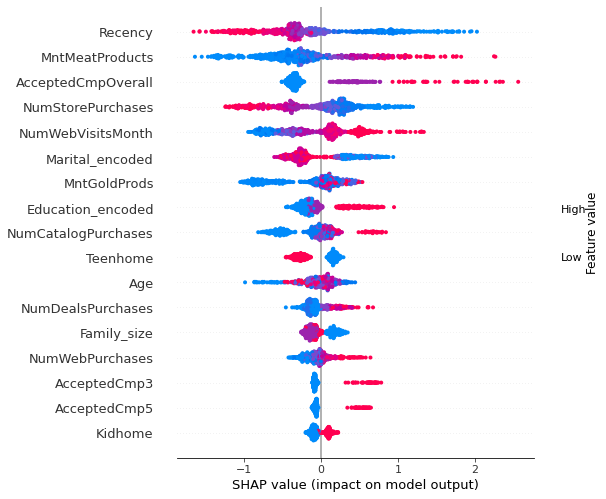

In [66]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_test[linear_rfe_features])
shap.summary_plot(shap_values, X_test[linear_rfe_features])

The plot can be interpreted as follows: On the y-axis we have all features used to train the model (and predict), while on the x-axis is shown a SHAP value, where, basically, a negative value means that the output is "pushed" towards class 0 (non-respondent) and a positive value indicates a pushing towards 1 (actual respondents). It's also possible to visualize the extend of the effect along different variables values, which are also colored as blue (lower values) to red (higher values).

For exemple, small values on the Recency column (frequent buyers) pushes the output towards class 1 (they are likely to accept).

Finally, it's also possible to check how each feature contributed to specific predictions using either a waterfall, force or decision plots. Here, I'll use decision plots. By using all data points, the chart is a completly mess, but it will be use in order to explain how to interpret it. Starting at the bottom, at the expected value point, shap values are cummulatively added as we move to the top, leading to the model decision (probabilities values (remember the treshold)). Features are ordered by importance (top feature importance at the top) and we can analyse its effects by visualizing how it's contributing to the decision path.

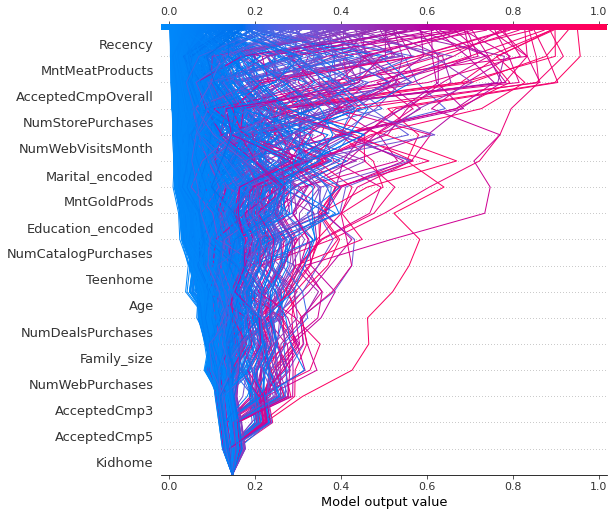

In [67]:
explainer = shap.TreeExplainer(xgb)
expected_value = explainer.expected_value[0]
shap_values = explainer.shap_values(X_test[linear_rfe_features])
shap.decision_plot(expected_value, shap_values, X_test[linear_rfe_features], link='logit')

Moving to a more "readable" chart, let's visualize the decision plot for rows 12 (response was 0) and 13 (response was 1).

In [68]:
X_test.iloc[12:14]

Kidhome  Teenhome  Recency  MntMeatProducts  MntGoldProds  \
1346        1         1       30              196            50   
971         0         0       46              708           182   

      NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
1346                  8                6                    1   
971                   1                9                    7   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp5  \
1346                  7                  8             0             0   
971                   9                  5             1             1   

      Marital_encoded  Age  AcceptedCmpOverall  Education_encoded  \
1346                1   48                   0                  1   
971                 2   53                   3                  1   

      Family_size  Cluster  y_test  y_pred  
1346            2        3       0       0  
971             0        2       1       1

Row = 12, Customer response was 0


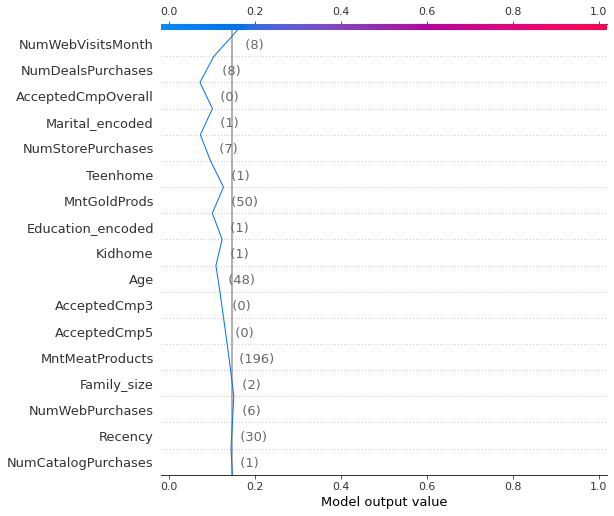

In [69]:
print('Row = 12, Customer response was 0')
explainer = shap.TreeExplainer(xgb)
expected_value = explainer.expected_value[0]
shap_values = explainer.shap_values(X_test[linear_rfe_features])

shap.decision_plot(expected_value, shap_values[12], X_test[linear_rfe_features].iloc[12], link='logit')

Row = 13, Customer response was 1


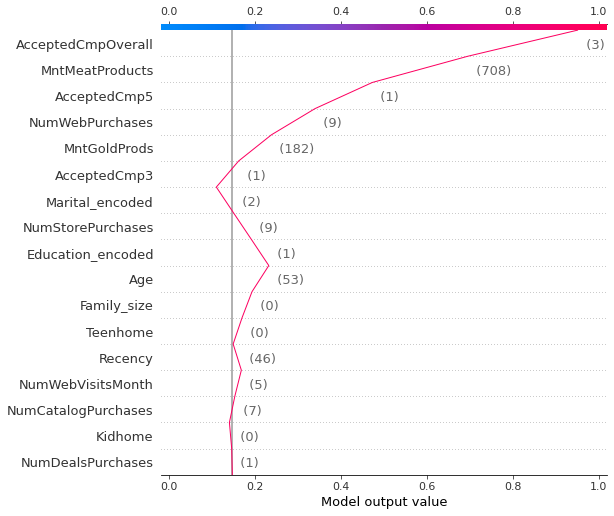

In [70]:
print('Row = 13, Customer response was 1')
explainer = shap.TreeExplainer(xgb)
expected_value = explainer.expected_value[0]
shap_values = explainer.shap_values(X_test[linear_rfe_features])

shap.decision_plot(expected_value, shap_values[13], X_test[linear_rfe_features].iloc[13], link='logit')

### Summary conclusion about predictions

The model is somewhat focusing on high income groups, whose recency is lower (frequent buyers) and consumption is high, they also have high past campaign acceptance, lower deals purchases and low size of family (usually 1 or 0 kids/teens). It also looks for people that buy more on catalogue than in store.

The model predicts that a higher education level are more likely to accept (PhDs have a slightly higher income), as well as Single people.